In [1]:
import pandas as pd
import seaborn as sns

In [2]:
results = pd.read_csv('../data/results.csv')

In [3]:
def results_points(a, b):
    """ Win, lose, draw 3, 0, 1 """
    if a > b:
        return [3, 0]
    if b > a:
        return [0, 3]
    if b == a:
        return [1, 1]
    else:
        return ValueError

In [4]:
results['Points'] = results.apply(lambda row: results_points(row['HomeScore'], row['AwayScore']), axis=1)
results[['HomePoints', 'AwayPoints']] = pd.DataFrame(results['Points'].tolist(), index=results.index)

In [5]:
season1 = results[results['SeasonID']==1]

In [6]:
def get_points_by_week(df):
    new_df = df.copy()
    home = new_df[['Gameweek', 'HomeTeamID', 'HomePoints']].copy()
    away = new_df[['Gameweek', 'AwayTeamID', 'AwayPoints']].copy()
    cols = ['Gameweek', 'ID', 'Points']
    home.columns = cols
    away.columns = cols
    points_by_week = pd.concat([home, away])
    return points_by_week

In [7]:
points_by_week_s1 = get_points_by_week(season1)

In [8]:
final_table_s1 = (points_by_week_s1.groupby(['ID'])['Points'].sum()
               .reset_index()
               .sort_values('Points', ascending=False)
               )
final_table_s1 = final_table_s1.reset_index().drop('index', axis=1)
final_table_s1.head(1)

,ID,Points
0,15,138


In [9]:
points_by_week_s1_ordered = points_by_week_s1.sort_values(['ID', 'Gameweek'])

In [10]:
points_by_week_s1_ordered['cum_points'] = points_by_week_s1_ordered.groupby(['ID'])['Points'].cumsum()

c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Gameweek', ylabel='cum_points'>

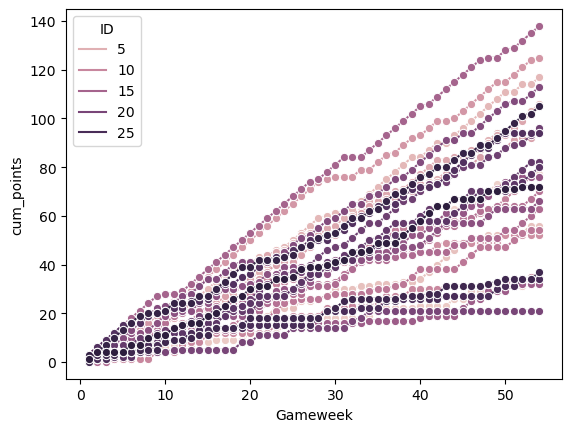

In [11]:
sns.lineplot(data=points_by_week_s1_ordered, x='Gameweek', y='cum_points', hue='ID', marker='o')

In [12]:
points_by_week_s1_ordered['max_remaining'] = (54 - points_by_week_s1_ordered['Gameweek']) * 3
points_by_week_s1_ordered['max_potential'] = points_by_week_s1_ordered['max_remaining'] + points_by_week_s1_ordered['cum_points']
# Add leader look up
max_points_lu = points_by_week_s1_ordered.groupby('Gameweek')['cum_points'].max().reset_index()
max_points_lu.columns = ['Gameweek', 'leader_points']
points_by_week_s1_ordered_lu = points_by_week_s1_ordered.merge(max_points_lu, on=['Gameweek'])

In [13]:
points_by_week_s1_ordered_lu['canwin'] = points_by_week_s1_ordered_lu.groupby('Gameweek').apply(lambda x : x['max_potential'] > x['leader_points']).reset_index()[0]

In [14]:
can_win_tot = points_by_week_s1_ordered_lu.groupby('Gameweek')['canwin'].sum().reset_index()
can_win_tot[can_win_tot['canwin'] == 1]['Gameweek'].min()

50

In [15]:
# Biggest upset?
# Odds Vs. results

In [16]:
odds = pd.read_csv('../data/odds.csv')

results_odds = results[['MatchID', 'SeasonID','HomePoints']].merge(odds, on=['MatchID'])

results_odds_s1 = results_odds[results_odds['SeasonID']==1].copy()

results_odds_s1['HomeWin'] = results_odds_s1['HomePoints'] == 3
results_odds_s1['HomeDraw'] = results_odds_s1['HomePoints'] == 1
results_odds_s1['AwayWin'] = results_odds_s1['HomePoints'] == 0

In [17]:
results_odds_s1['upset_total'] = (results_odds_s1['Home'] * results_odds_s1['HomeWin'] + 
                                  results_odds_s1['Draw'] * results_odds_s1['HomeDraw'] + 
                                  results_odds_s1['Away'] * results_odds_s1['AwayWin'])

In [18]:
results_odds_s1[results_odds_s1['upset_total'].max()==results_odds_s1['upset_total']]

,MatchID,SeasonID,HomePoints,Home,Draw,Away,HomeWin,HomeDraw,AwayWin,upset_total
167,168,1,1,1.03,23.35,75.22,False,True,False,23.35


In [19]:
results[results['MatchID']==168]

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Points,HomePoints,AwayPoints
167,1,12,168,15,3,38,16,3,10,"[1, 1]",1,1
